In [36]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf 
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 11s 0us/step


In [37]:
pathlib.os.listdir(DATASET_PATH)

['no', 'README.md', 'yes', 'left', 'right', 'go', 'down', 'stop', 'up']

In [38]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
len(commands)

9

In [39]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [40]:
for audio_signal,audio_label in train_ds.take(1):
  print(audio_signal.shape)
  print(audio_label.shape)

(64, 16000, 1)
(64,)


In [63]:
audio_signal[10]

<tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[6.1035156e-05],
       [6.1035156e-05],
       [9.1552734e-05],
       ...,
       [1.5258789e-04],
       [1.5258789e-04],
       [1.5258789e-04]], dtype=float32)>

In [62]:
audio_label[10]

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [43]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [10]:
for audio_signal,audio_label in train_ds.take(1):
  print(audio_signal.shape)
  print(audio_label.shape)

(64, 16000)
(64,)


In [44]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [45]:
for example_audio,example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


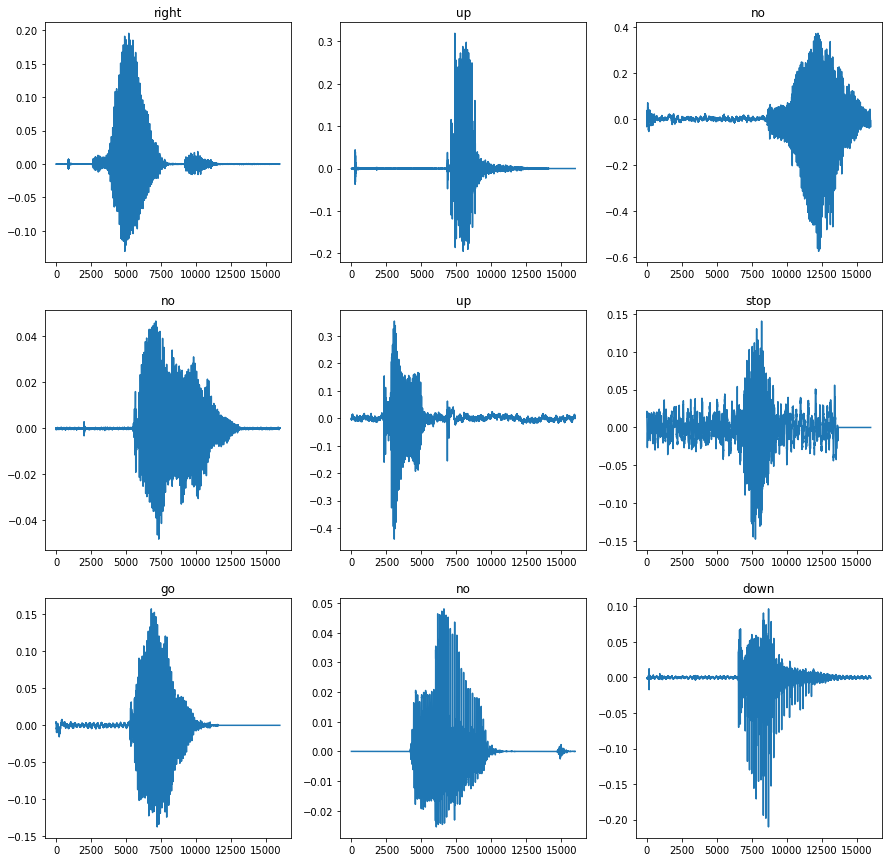

In [46]:
plt.figure(figsize=(15,15))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.plot(example_audio[i])
  plt.title(label_names[example_labels[i]])

In [47]:
from IPython import display

In [48]:
normal_waveform = example_audio[1]
print(normal_waveform.shape)
spectrogram = tf.signal.stft(normal_waveform,frame_length=255,frame_step=128)
print(spectrogram.shape)

(16000,)
(124, 129)


In [49]:
example_audio.shape

TensorShape([64, 16000])

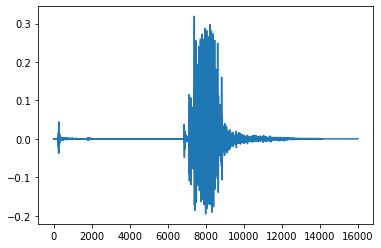

In [50]:
plt.plot(normal_waveform)

In [51]:
tf.expand_dims(spectrogram,axis=-1).shape

TensorShape([124, 129, 1])

In [52]:
normal_waveform[0]

<tf.Tensor: shape=(), dtype=float32, numpy=-6.1035156e-05>

In [53]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform,frame_length = 255,frame_step = 128)
  spectrogram = tf.abs(spectrogram)
  #docs: spectrogram = spectrogram[...,tf.newaxis]
  spectrogram = tf.expand_dims(spectrogram,axis=-1)
  return spectrogram

In [54]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [56]:
def plot_spectrogram(spectrogram,ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram  = np.squeeze(spectrogram,axis=-1)
  #print(spectrogram)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  print(log_spec)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0,np.size(spectrogram),num=width,dtype=int)
  Y = range(height)
  ax.pcolormesh(X,Y,log_spec)

[[ -0.48054522  -0.38986552  -0.92145395 ...  -1.6865569   -1.3988696
   -1.4318361 ]
 [  0.7487027    0.53548366  -0.22206774 ...  -1.4501582   -1.9182464
   -2.0109408 ]
 [  1.0659071    0.50947773   0.2798588  ...   0.29153162   0.1024145
    0.14558505]
 ...
 [ -8.980251    -7.970708    -7.520323   ...  -8.154662    -9.172427
   -8.4874325 ]
 [-10.299492    -8.278284    -8.055021   ... -10.460609   -10.21736
   -8.34708   ]
 [-14.843773    -8.53841     -9.544622   ...  -9.2307205   -9.258243
   -8.781588  ]]


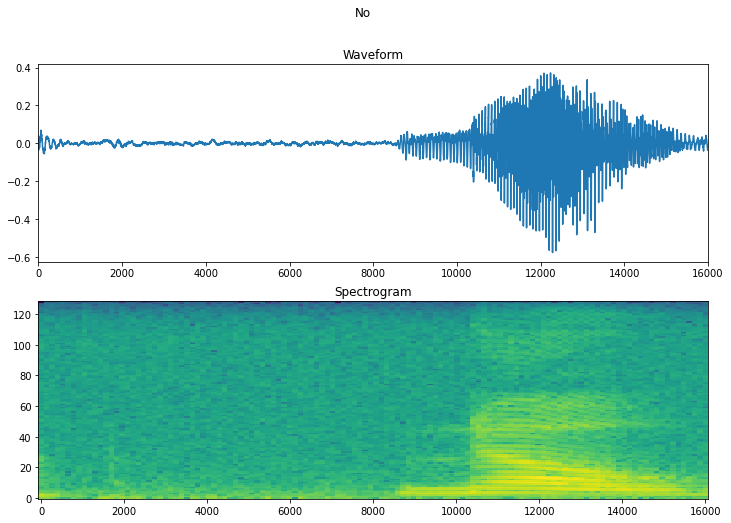

In [57]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [67]:
def make_spec_ds(dataset):
  return dataset.map(lambda audio,label: (get_spectrogram(audio),label),tf.data.AUTOTUNE)

In [69]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [70]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  print(example_spectrograms.shape)
  print(example_spect_labels.shape)

(64, 124, 129, 1)
(64,)


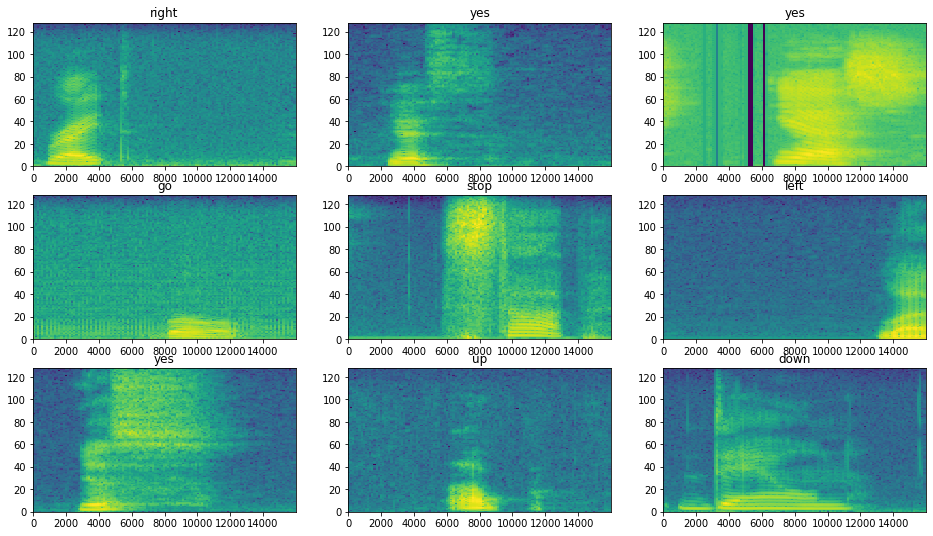

In [ ]:
rows = 3
cols = 3
n = rows*cols

plt.figure(figsize=(16,9))
for i in range(n):
  plt.subplot(rows,cols,i+1)
  plot_spectrogram(example_spectrograms[i],plt)
  plt.title(label_names[example_spect_labels[i]])

In [71]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [74]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
print(num_labels)
label_names

Input shape: (124, 129, 1)
8


array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U5')

In [75]:
from keras import layers,models

In [79]:

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
for aud,lab in train_spectrogram_ds.take(1):
  print(lab)
print(norm_layer)

tf.Tensor(
[6 2 2 2 5 7 0 4 0 4 3 1 2 6 3 2 4 4 1 3 4 0 6 1 0 5 5 5 4 2 3 5 3 5 1 7 4
 1 0 4 4 1 7 4 5 1 2 7 7 1 6 7 6 6 1 7 2 0 4 1 6 3 2 2], shape=(64,), dtype=int32)


In [80]:

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)       

In [81]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [82]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 14s 36ms/step - loss: 1.7588 - accuracy: 0.3634 - val_loss: 1.3627 - val_accuracy: 0.5781
Epoch 2/10
100/100 [==============================] - 1s 10ms/step - loss: 1.2096 - accuracy: 0.5752 - val_loss: 0.9691 - val_accuracy: 0.6797
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.9397 - accuracy: 0.6712 - val_loss: 0.8097 - val_accuracy: 0.7344
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.7638 - accuracy: 0.7242 - val_loss: 0.6862 - val_accuracy: 0.7799
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6561 - accuracy: 0.7620 - val_loss: 0.6490 - val_accuracy: 0.8190
Epoch 6/10
100/100 [==============================] - 1s 8ms/step - loss: 0.5697 - accuracy: 0.8028 - val_loss: 0.5724 - val_accuracy: 0.8073
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5070 - accuracy: 0.8208 - val_loss: 0.5561 - val_accuracy: 0.8242
Epo

Text(0, 0.5, 'Accuracy [%]')

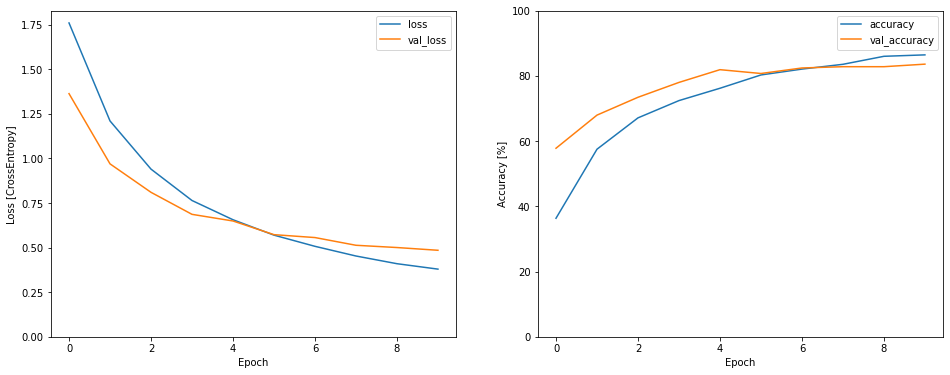

In [83]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [84]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 2s 81ms/step


In [85]:
y_pred = tf.argmax(y_pred,axis=1)

In [86]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)